## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
import optuna
import time
import lightgbm as lgb
import os
from sklearn.metrics import root_mean_squared_error
from scipy.optimize import minimize as sp_minimize
from sklearn.preprocessing import StandardScaler
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

d:\Program Files\conda_envs\nitor_kuas\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configs

In [2]:
train_path = '../data/train.csv'
test_path = '../data/test_for_participants.csv'
sample_path = '../data/sample_submission.csv'
VAL_START = '2025-06-01'
SEED = 42
N_TRIALS_LGB = 30
SAVED_LGB_PATH = '../models/lgb_final.txt'
ROUND_MULTIPLIER = 1.15

os.makedirs('../models', exist_ok=True)

# Set random seed for reproducibility
np.random.seed(SEED)

## Data loading

In [3]:
train_raw = pd.read_csv(train_path)
test_raw = pd.read_csv(test_path)
sample_sub = pd.read_csv(sample_path)

In [4]:
for df in [train_raw, test_raw]:
    df['delivery_start'] = pd.to_datetime(df['delivery_start'])
    df['delivery_end'] = pd.to_datetime(df['delivery_end'])

train_raw['is_test'] = 0
test_raw['is_test'] = 1
test_raw['target'] = np.nan

df = pd.concat([train_raw, test_raw], ignore_index=True)
df = df.sort_values(['market', 'delivery_start']).reset_index(drop=True)
df.head()

,id,target,market,global_horizontal_irradiance,diffuse_horizontal_irradiance,direct_normal_irradiance,cloud_cover_total,cloud_cover_low,cloud_cover_mid,cloud_cover_high,...,wind_speed_80m,wind_direction_80m,wind_gust_speed_10m,wind_speed_10m,solar_forecast,wind_forecast,load_forecast,delivery_start,delivery_end,is_test
0,0,-1.913,Market A,0.0,0.0,0.0,2.0,0.0,0.0,2.0,...,31.253719,245.501450,25.199999,15.077082,0.0,24050.1,38163.0100,2023-01-01 00:00:00,2023-01-01 01:00:00,0
1,5,-0.839,Market A,0.0,0.0,0.0,15.0,0.0,0.0,15.0,...,30.918108,242.241547,23.400000,14.186923,0.0,23886.3,37379.1898,2023-01-01 01:00:00,2023-01-01 02:00:00,0
2,10,-1.107,Market A,0.0,0.0,0.0,17.0,0.0,0.0,17.0,...,26.983196,224.999893,21.240000,12.413477,0.0,23366.5,36336.8303,2023-01-01 02:00:00,2023-01-01 03:00:00,0
3,15,0.035,Market A,0.0,0.0,0.0,16.0,0.0,0.0,16.0,...,22.218153,229.600174,16.199999,10.483357,0.0,22829.8,35337.7595,2023-01-01 03:00:00,2023-01-01 04:00:00,0
4,20,-0.829,Market A,0.0,0.0,0.0,10.0,0.0,0.0,10.0,...,27.210381,244.113022,18.359999,11.918120,0.0,22347.6,34474.3403,2023-01-01 04:00:00,2023-01-01 05:00:00,0


## Enhanced Feature Engineering - Ultra Advanced Version

In [5]:
# Basic time features
ds = df["delivery_start"]
df["hour"]         = ds.dt.hour
df["day_of_week"]  = ds.dt.dayofweek
df["day_of_month"] = ds.dt.day
df["month"]        = ds.dt.month
df["quarter"]      = ds.dt.quarter
df["day_of_year"]  = ds.dt.dayofyear
df["year"]         = ds.dt.year
df["is_weekend"]   = (ds.dt.dayofweek >= 5).astype(np.int8)
df["week_of_year"] = ds.dt.isocalendar().week.astype(int)

# Cyclical encoding for time features
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

# Market encoding
market_map = {f"Market {c}": i for i, c in enumerate("ABCDEF")}
df["market_id"] = df["market"].map(market_map).astype(np.int8)

# Advanced demand and supply features
df["residual_demand"] = df["load_forecast"] - df["solar_forecast"] - df["wind_forecast"]
df["supply_ratio"] = (df["solar_forecast"] + df["wind_forecast"]) / (df["load_forecast"] + 1)
df["renewable_ratio"] = (df["solar_forecast"] + df["wind_forecast"]) / (df["solar_forecast"] + df["wind_forecast"] + df["load_forecast"] + 1)
df["net_supply"] = df["solar_forecast"] + df["wind_forecast"]
df["demand_supply_balance"] = df["load_forecast"] / (df["solar_forecast"] + df["wind_forecast"] + 1)

# Tightness ratios
df["tightness_ratio"] = df["residual_demand"] / (df["load_forecast"] + 1)
df["tightness_x_month"] = df["tightness_ratio"] * df["month"]
df["tightness_x_hour"] = df["tightness_ratio"] * df["hour"]
df["tightness_x_dow"] = df["tightness_ratio"] * df["day_of_week"]

# Price sensitivity indicators
df["solar_wind_ratio"] = df["solar_forecast"] / (df["wind_forecast"] + 1)
df["wind_solar_ratio"] = df["wind_forecast"] / (df["solar_forecast"] + 1)

In [6]:
# ── Advanced Weather Physics Features ──────────────────────────────────────
# First, alias columns whose names differ between dataset and our code

if 'convective_available_potential_energy' in df.columns:
    df['cape'] = df['convective_available_potential_energy']
if 'precipitation_amount' in df.columns:
    df['precipitation'] = df['precipitation_amount']
if 'apparent_temperature_2m' in df.columns:
    df['apparent_temperature'] = df['apparent_temperature_2m']
if 'freezing_level_height' in df.columns:
    df['boundary_layer_height'] = df['freezing_level_height']

# Estimate missing columns from available physics
# Saturation vapour pressure (Tetens formula)
es = 6.112 * np.exp((17.67 * df['air_temperature_2m']) / (df['air_temperature_2m'] + 243.5))
ea = (df['relative_humidity_2m'] / 100.0) * es
df['vapour_pressure_deficit_2m'] = es - ea

# Proxy precipitation probability from relative humidity
df['precipitation_probability'] = np.where(df['relative_humidity_2m'] > 85, 50, 0)

# ── Derived weather features ──
df['dew_point_depression']  = df['air_temperature_2m'] - df['dew_point_temperature_2m']
df['wet_bulb_depression']   = df['air_temperature_2m'] - df['wet_bulb_temperature_2m']
df['humidity_ratio']        = (0.622 * df['vapour_pressure_deficit_2m']) / (df['surface_pressure'] - df['vapour_pressure_deficit_2m'])
df['blh_normalized_pressure'] = df['boundary_layer_height'] / (df['surface_pressure'] / 1000)

# Wind shear (10m vs 80m)
df['wind_shear']       = df['wind_speed_80m'] - df['wind_speed_10m']
df['wind_shear_ratio'] = df['wind_speed_80m'] / (df['wind_speed_10m'] + 0.1)

# Convection indices
df['cape_cin_interaction'] = df['cape'] * df['convective_inhibition']
df['convection_potential'] = df['cape'] / (abs(df['convective_inhibition']) + 1)

# Visibility & cloud
df['visibility_cloud_interaction'] = df['visibility'] / (df['cloud_cover_total'] + 1)

# Combined weather severity index
df['weather_severity'] = (
    df['cloud_cover_total'] / 100 +
    (100 - df['visibility'].clip(0, 100)) / 100 +
    df['precipitation_probability'] / 100 +
    df['cape'] / 1000
) / 4

# Solar / wind potential
df['solar_potential'] = df['global_horizontal_irradiance'] * (1 - df['cloud_cover_total'] / 100)
df['wind_potential']  = df['wind_speed_80m'] ** 3  # cubic ∝ power

# Extreme weather flags
df['extreme_temp']   = ((df['air_temperature_2m'] > 30) | (df['air_temperature_2m'] < -5)).astype(int)
df['extreme_wind']   = (df['wind_speed_80m'] > 25).astype(int)
df['extreme_precip'] = (df['precipitation'] > 5).astype(int)

# Seasonal × weather interactions
df['temp_month_interaction'] = df['air_temperature_2m'] * df['month']
df['wind_month_interaction'] = df['wind_speed_80m'] * df['month']
df['solar_hour_interaction'] = df['solar_forecast'] * df['hour']

# Heating / cooling degree-hours
df['cooling_degree_hours'] = np.maximum(df['air_temperature_2m'] - 22, 0)
df['heating_degree_hours'] = np.maximum(18 - df['air_temperature_2m'], 0)

# Vapour pressure deficit normalised
df['vpd_normalized'] = df['vapour_pressure_deficit_2m'] / df['surface_pressure']

# Apparent temperature anomaly
df['apparent_temp_anomaly']   = df['apparent_temperature'] - df['air_temperature_2m']
df['apparent_air_temp_ratio'] = df['apparent_temperature'] / (df['air_temperature_2m'] + 1)

# Lifted Index feature (strong storm predictor)
if 'lifted_index' in df.columns:
    df['lifted_index_negative'] = (-df['lifted_index']).clip(lower=0)  # only instability

In [7]:
# ── Weather Momentum & Lag Features (NO target leakage) ────────────────────
weather_cols = ['wind_speed_80m', 'solar_forecast', 'load_forecast',
                'wind_forecast', 'air_temperature_2m']

for col in weather_cols:
    grp = df.groupby('market_id')[col]

    # Hourly differences (momentum)
    df[f'{col}_diff_1h']  = grp.diff(1)
    df[f'{col}_diff_3h']  = grp.diff(3)
    df[f'{col}_diff_6h']  = grp.diff(6)
    df[f'{col}_diff_12h'] = grp.diff(12)

    # Rolling mean / std
    df[f'{col}_rolling_mean_6h']  = grp.transform(lambda x: x.rolling(6,  min_periods=1).mean())
    df[f'{col}_rolling_std_6h']   = grp.transform(lambda x: x.rolling(6,  min_periods=1).std().fillna(0))
    df[f'{col}_rolling_mean_24h'] = grp.transform(lambda x: x.rolling(24, min_periods=1).mean())
    df[f'{col}_rolling_std_24h']  = grp.transform(lambda x: x.rolling(24, min_periods=1).std().fillna(0))

    # Rolling min / max (use bfill() instead of deprecated fillna(method=...))
    df[f'{col}_rolling_min_24h'] = grp.transform(lambda x: x.rolling(24, min_periods=1).min().bfill())
    df[f'{col}_rolling_max_24h'] = grp.transform(lambda x: x.rolling(24, min_periods=1).max().bfill())
    df[f'{col}_range_24h']       = df[f'{col}_rolling_max_24h'] - df[f'{col}_rolling_min_24h']

    # Exponential weighted moving averages
    df[f'{col}_ewm_6h']  = grp.transform(lambda x: x.ewm(span=6,  adjust=False).mean())
    df[f'{col}_ewm_24h'] = grp.transform(lambda x: x.ewm(span=24, adjust=False).mean())

    # Z-score vs rolling window
    df[f'{col}_zscore_24h'] = (df[col] - df[f'{col}_rolling_mean_24h']) / (df[f'{col}_rolling_std_24h'] + 0.001)

# Temperature anomaly vs recent history
df['temp_24h_mean']    = df.groupby('market_id')['air_temperature_2m'].transform(lambda x: x.rolling(24, min_periods=1).mean())
df['temp_72h_mean']    = df.groupby('market_id')['air_temperature_2m'].transform(lambda x: x.rolling(72, min_periods=1).mean())
df['temp_anomaly_24h'] = df['air_temperature_2m'] - df['temp_24h_mean']
df['temp_anomaly_72h'] = df['air_temperature_2m'] - df['temp_72h_mean']

# Wind direction components & stability
df['wind_dir_sin']    = np.sin(np.deg2rad(df['wind_direction_80m']))
df['wind_dir_cos']    = np.cos(np.deg2rad(df['wind_direction_80m']))
df['wind_dir_change'] = df.groupby('market_id')['wind_direction_80m'].diff(1).abs()

# Pressure & humidity interactions with temperature
df['pressure_temp_interaction']  = df['surface_pressure'] * df['air_temperature_2m']
df['humidity_temp_interaction']  = df['relative_humidity_2m'] * df['air_temperature_2m']
df['pressure_gradient']          = df.groupby('market_id')['surface_pressure'].diff(1)

# Cloud & precipitation transforms
df['cloud_cover_total_sq']  = df['cloud_cover_total'] ** 2
df['cloud_cover_effect']    = df['cloud_cover_total'] * df['global_horizontal_irradiance']
df['precip_prob_sq']        = df['precipitation_probability'] ** 2
df['precip_effect']         = df['precipitation'] * df['precipitation_probability']

# Radiation efficiency
df['solar_efficiency']       = df['solar_forecast'] / (df['global_horizontal_irradiance'] + 1)
df['radiation_cloud_ratio']  = df['global_horizontal_irradiance'] / (df['cloud_cover_total'] + 1)

In [8]:
# Advanced temporal features

# Hourly and daily patterns
df['hour_from_peak'] = abs(df['hour'] - 12)  # Distance from peak solar hour
df['is_peak_solar'] = ((df['hour'] >= 10) & (df['hour'] <= 16)).astype(int)
df['is_off_peak'] = ((df['hour'] >= 22) | (df['hour'] <= 6)).astype(int)
df['is_business_hours'] = ((df['hour'] >= 8) & (df['hour'] <= 18) & (df['day_of_week'] < 5)).astype(int)

# Week patterns
df['is_monday'] = (df['day_of_week'] == 0).astype(int)
df['is_friday'] = (df['day_of_week'] == 4).astype(int)
df['is_weekend_start'] = (df['day_of_week'] == 4).astype(int)  # Friday
df['is_weekend_end'] = (df['day_of_week'] == 6).astype(int)    # Sunday

# Monthly patterns
df['is_winter'] = df['month'].isin([12, 1, 2]).astype(int)
df['is_summer'] = df['month'].isin([6, 7, 8]).astype(int)
df['is_spring'] = df['month'].isin([3, 4, 5]).astype(int)
df['is_autumn'] = df['month'].isin([9, 10, 11]).astype(int)

# Quarter interactions
df['q1_temp_interaction'] = (df['quarter'] == 1) * df['air_temperature_2m']
df['q2_temp_interaction'] = (df['quarter'] == 2) * df['air_temperature_2m']
df['q3_temp_interaction'] = (df['quarter'] == 3) * df['air_temperature_2m']
df['q4_temp_interaction'] = (df['quarter'] == 4) * df['air_temperature_2m']

# Seasonal demand patterns
df['winter_load_factor'] = df['is_winter'] * df['load_forecast']
df['summer_load_factor'] = df['is_summer'] * df['load_forecast']
df['spring_load_factor'] = df['is_spring'] * df['load_forecast']
df['autumn_load_factor'] = df['is_autumn'] * df['load_forecast']

In [9]:
# ══════════════════════════════════════════════════════════════════════════════
# SAFE Historical Target Encoding  (ZERO leakage into Val / Test)
# ══════════════════════════════════════════════════════════════════════════════
# We compute group means using ONLY the strict training period
# (exclude both Validation AND Test rows), then merge onto the full dataframe.
# Val/Test rows receive the frozen training-period mean — no future information.

strict_train = df[(df['is_test'] == 0) & (df['delivery_start'] < VAL_START)]

# ── Market × Hour mean ──
mean_mh = (strict_train
    .groupby(['market_id', 'hour'])['target']
    .mean().reset_index(name='target_histmean_mh'))

# ── Market × Day-of-week mean ──
mean_mdow = (strict_train
    .groupby(['market_id', 'day_of_week'])['target']
    .mean().reset_index(name='target_histmean_mdow'))

# ── Market × Month mean ──
mean_mm = (strict_train
    .groupby(['market_id', 'month'])['target']
    .mean().reset_index(name='target_histmean_mm'))

# ── Market mean (global baseline per market) ──
mean_m = (strict_train
    .groupby(['market_id'])['target']
    .mean().reset_index(name='target_histmean_m'))

# ── Hour mean (global baseline per hour) ──
mean_h = (strict_train
    .groupby(['hour'])['target']
    .mean().reset_index(name='target_histmean_h'))

# ── Market × Hour × DayOfWeek mean ──
mean_mhd = (strict_train
    .groupby(['market_id', 'hour', 'day_of_week'])['target']
    .mean().reset_index(name='target_histmean_mhd'))

# ── Market × Quarter mean ──
mean_mq = (strict_train
    .groupby(['market_id', 'quarter'])['target']
    .mean().reset_index(name='target_histmean_mq'))

# Merge ALL onto full dataframe
df = df.merge(mean_mh,  on=['market_id', 'hour'],          how='left')
df = df.merge(mean_mdow, on=['market_id', 'day_of_week'],  how='left')
df = df.merge(mean_mm,  on=['market_id', 'month'],          how='left')
df = df.merge(mean_m,   on=['market_id'],                   how='left')
df = df.merge(mean_h,   on=['hour'],                        how='left')
df = df.merge(mean_mhd, on=['market_id', 'hour', 'day_of_week'], how='left')
df = df.merge(mean_mq,  on=['market_id', 'quarter'],       how='left')

# Fill any NaN hist-means with global training mean
global_mean = strict_train['target'].mean()
for c in [c for c in df.columns if c.startswith('target_histmean_')]:
    df[c] = df[c].fillna(global_mean)

# ── Deviations from historical baselines (computed from safe features only) ──
df['histmean_mh_x_residual'] = df['target_histmean_mh'] * df['residual_demand']
df['histmean_mh_x_tightness'] = df['target_histmean_mh'] * df['tightness_ratio']
df['histmean_deviation_dow_vs_m'] = df['target_histmean_mdow'] - df['target_histmean_m']
df['histmean_deviation_mh_vs_h'] = df['target_histmean_mh'] - df['target_histmean_h']

print(f"✅ Safe historical encoding: {sum(c.startswith('target_histmean') for c in df.columns)} features")
print(f"   Global training mean: {global_mean:.4f}")

✅ Safe historical encoding: 7 features
   Global training mean: 33.9777


In [10]:
# ── Interaction features (weather × demand, cross-market) ──────────────────
df['temp_load_interaction']  = df['air_temperature_2m'] * df['load_forecast']
df['wind_load_interaction']  = df['wind_speed_80m'] * df['load_forecast']
df['solar_load_interaction'] = df['solar_forecast'] * df['load_forecast']
df['temp_wind_interaction']  = df['air_temperature_2m'] * df['wind_speed_80m']
df['temp_solar_interaction'] = df['air_temperature_2m'] * df['solar_forecast']
df['wind_solar_interaction'] = df['wind_speed_80m'] * df['solar_forecast']

# Triple interactions
df['temp_wind_load_interaction']  = df['air_temperature_2m'] * df['wind_speed_80m'] * df['load_forecast']
df['temp_solar_load_interaction'] = df['air_temperature_2m'] * df['solar_forecast'] * df['load_forecast']
df['wind_solar_load_interaction'] = df['wind_speed_80m'] * df['solar_forecast'] * df['load_forecast']

# Weather volatility (rolling on weather — safe, no target)
df['temp_volatility']  = df.groupby('market_id')['air_temperature_2m'].transform(lambda x: x.rolling(24, min_periods=1).std().fillna(0))
df['wind_volatility']  = df.groupby('market_id')['wind_speed_80m'].transform(lambda x: x.rolling(24, min_periods=1).std().fillna(0))
df['solar_volatility'] = df.groupby('market_id')['solar_forecast'].transform(lambda x: x.rolling(24, min_periods=1).std().fillna(0))

# Rate of change (weather — safe)
df['temp_rate_change']  = df.groupby('market_id')['air_temperature_2m'].diff(1) / (df.groupby('market_id')['air_temperature_2m'].shift(1).abs() + 0.01)
df['wind_rate_change']  = df.groupby('market_id')['wind_speed_80m'].diff(1) / (df.groupby('market_id')['wind_speed_80m'].shift(1).abs() + 0.01)
df['solar_rate_change'] = df.groupby('market_id')['solar_forecast'].diff(1) / (df.groupby('market_id')['solar_forecast'].shift(1).abs() + 0.01)

# Cross-market features (same timestamp, across markets — safe)
for col in ['wind_speed_80m', 'solar_forecast', 'load_forecast']:
    ts_mean = df.groupby('delivery_start')[col].transform('mean')
    ts_std  = df.groupby('delivery_start')[col].transform('std') + 0.001
    df[f'{col}_market_diff']   = df[col] - ts_mean
    df[f'{col}_market_zscore'] = (df[col] - ts_mean) / ts_std

# Advanced rolling statistics (weather — safe)
for col in ['wind_speed_80m', 'solar_forecast', 'load_forecast']:
    df[f'{col}_skew_24h'] = df.groupby('market_id')[col].transform(
        lambda x: x.rolling(24, min_periods=12).skew().fillna(0))

# ── Final NaN handling ─────────────────────────────────────────────────────
# NEVER fill target NaN — those are test rows!
exclude_from_fill = {'target', 'delivery_start', 'delivery_end', 'market', 'id'}
for col in df.columns:
    if col in exclude_from_fill:
        continue
    if df[col].dtype in ['float64', 'float32', 'int64', 'int32', 'int8']:
        nan_count = df[col].isna().sum()
        if nan_count > 0:
            df[col] = df[col].fillna(df[col].median())

print(f"✅ Feature engineering complete: {len(df.columns)} total columns")
print(f"   Training rows: {(df['is_test']==0).sum()}, Test rows: {(df['is_test']==1).sum()}")
print(f"   NaN check (target): {df['target'].isna().sum()} NaN (should equal test rows)")

✅ Feature engineering complete: 232 total columns
   Training rows: 132608, Test rows: 13098
   NaN check (target): 13098 NaN (should equal test rows)


## Prepare X and y

In [11]:
observed_df = df[df['is_test'] == 0].copy()
test_df = df[df['is_test'] == 1].copy()

val_mask = observed_df['delivery_start'] >= VAL_START
train_df = observed_df[~val_mask]
val_df = observed_df[val_mask]

In [12]:
drop_cols = set(['id', 'target', 'market', 'delivery_start', 'delivery_end', 'is_test'])
feat_cols = sorted([c for c in df.columns if c not in drop_cols])
cat_idx = [feat_cols.index('market_id')] if 'market_id' in feat_cols else []

X_train = train_df[feat_cols]
y_train_real = train_df['target'].values
y_train = np.arcsinh(train_df['target'].values)

X_val = val_df[feat_cols]
y_val_real = val_df['target'].values
y_val = np.arcsinh(val_df['target'].values)

X_all = observed_df[feat_cols]
y_all_real = observed_df['target'].values
y_all = np.arcsinh(observed_df['target'].values)

X_test = test_df[feat_cols]

## LightGBM baseline with ultra-enhanced features

In [13]:
print("Starting baseline evaluation...")
start_time = time.time()

# Enhanced hyperparameters for better performance
baseline_params = {
    "objective": "huber",     # Robust to the massive price spikes
    "alpha": 1.0,             # Adjusted Huber threshold
    "metric": "rmse",
    "verbosity": -1,
    "seed": 42,               # STRICTLY FIXED for reproducibility
    "n_jobs": -1,
    
    # Tree Structure (Optimized for complex features)
    "max_depth": 14,          # Deeper to capture complex interactions
    "num_leaves": 415,        # More leaves for complex patterns
    "min_child_samples": 20,  # Reduced to allow more splits
    
    # Learning & Sampling
    "learning_rate": 0.012,    # Slower learning for better convergence
    "feature_fraction": 0.88,  # Use 88% of features per tree
    "bagging_fraction": 0.90,  # Use 90% of samples per tree
    "bagging_freq": 1,        # Perform bagging every iteration
    
    # Regularization
    "reg_alpha": 0.12,         # L1 regularization
    "reg_lambda": 0.12         # L2 regularization
}

# Prepare datasets
dataset_train = lgb.Dataset(X_train, y_train, categorical_feature=cat_idx if cat_idx else 'auto', free_raw_data=False)
dataset_val = lgb.Dataset(X_val, y_val, reference=dataset_train, free_raw_data=False)

# Record learning curve
evals_result = {}

# Train the Model — pass BOTH train & val so we can track overfitting
model = lgb.train(
    baseline_params, 
    dataset_train, 
    num_boost_round=3000,
    valid_sets=[dataset_train, dataset_val],
    valid_names=['train', 'val'],
    callbacks=[
        lgb.early_stopping(100, verbose=False),
        lgb.log_evaluation(200),
        lgb.record_evaluation(evals_result),
    ],
)

# Predict on TRAIN set (back-transformed)
train_preds_raw = model.predict(X_train)
train_preds_real = np.sinh(train_preds_raw)
train_rmse = root_mean_squared_error(y_train_real, train_preds_real)

# Predict on VAL set (back-transformed)
val_preds_raw = model.predict(X_val)
real_preds = np.sinh(val_preds_raw)
final_rmse = root_mean_squared_error(y_val_real, real_preds)

# Summary
overfit_ratio = train_rmse / final_rmse if final_rmse > 0 else float('inf')

print("\n" + "="*55)
print(f"\U0001f3af  TRAIN RMSE: {train_rmse:.4f}")
print(f"\u2705  VAL   RMSE: {final_rmse:.4f}")
print(f"\U0001f4ca  Ratio (train/val): {overfit_ratio:.4f}  {'\u26a0\ufe0f OVERFITTING' if overfit_ratio < 0.6 else '\u2705 OK' if overfit_ratio > 0.85 else '\U0001f7e1 MILD OVERFIT'}")
print(f"   Iterations: {model.best_iteration}")
print(f"   Time taken: {time.time() - start_time:.0f}s")
print("="*55 + "\n")

# Print Top 10 features
imp = pd.Series(model.feature_importance("gain"), index=feat_cols)
print("Top 10 Features (Gain):")
print(imp.nlargest(10).round(0))

Starting baseline evaluation...
[200]	train's rmse: 1.71875	val's rmse: 1.53803
[400]	train's rmse: 1.40309	val's rmse: 1.45174
[600]	train's rmse: 1.19825	val's rmse: 1.41897
[800]	train's rmse: 1.05973	val's rmse: 1.4103

🎯  TRAIN RMSE: 91.5558
✅  VAL   RMSE: 42.8824
📊  Ratio (train/val): 2.1350  ✅ OK
   Iterations: 774
   Time taken: 113s

Top 10 Features (Gain):
tightness_ratio           1163557.0
renewable_ratio            551236.0
wind_potential             542036.0
demand_supply_balance      324584.0
residual_demand            182288.0
market_id                  159775.0
histmean_mh_x_residual     126986.0
wind_speed_80m_ewm_6h      125421.0
year                        99460.0
target_histmean_mm          96518.0
dtype: float64


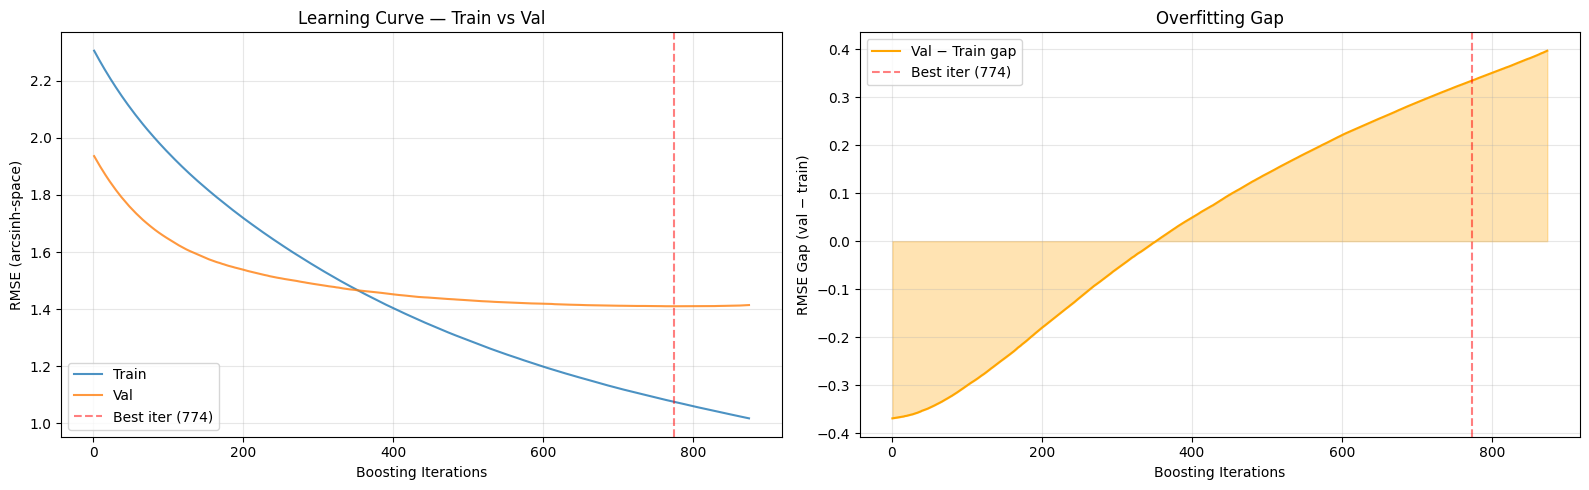


📅 RMSE BY MONTH (VALIDATION SET)
Month 06 | Rows: 4320 | RMSE: 29.1780
Month 07 | Rows: 4464 | RMSE: 45.2311
Month 08 | Rows: 4464 | RMSE: 50.8688

🏭 RMSE BY MARKET (VALIDATION SET)
Market 0 | Rows: 2208 | RMSE: 90.8062
Market 1 | Rows: 2208 | RMSE: 24.8595
Market 2 | Rows: 2208 | RMSE: 24.0774
Market 3 | Rows: 2208 | RMSE: 24.7024
Market 4 | Rows: 2208 | RMSE: 24.9793
Market 5 | Rows: 2208 | RMSE: 18.8615



In [14]:
# ── Learning Curve Plot (Overfitting Diagnostic) ──────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# LEFT: Raw learning curve (arcsinh-space RMSE from LightGBM)
train_rmse_curve = evals_result['train']['rmse']
val_rmse_curve   = evals_result['val']['rmse']
iters = range(1, len(train_rmse_curve) + 1)

axes[0].plot(iters, train_rmse_curve, label='Train', alpha=0.8, linewidth=1.5)
axes[0].plot(iters, val_rmse_curve,   label='Val',   alpha=0.8, linewidth=1.5)
axes[0].axvline(x=model.best_iteration, color='red', linestyle='--', alpha=0.5, label=f'Best iter ({model.best_iteration})')
axes[0].set_xlabel('Boosting Iterations')
axes[0].set_ylabel('RMSE (arcsinh-space)')
axes[0].set_title('Learning Curve — Train vs Val')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# RIGHT: Gap between train and val (overfit indicator)
gap = [v - t for t, v in zip(train_rmse_curve, val_rmse_curve)]
axes[1].fill_between(iters, 0, gap, alpha=0.3, color='orange')
axes[1].plot(iters, gap, color='orange', linewidth=1.5, label='Val − Train gap')
axes[1].axvline(x=model.best_iteration, color='red', linestyle='--', alpha=0.5, label=f'Best iter ({model.best_iteration})')
axes[1].set_xlabel('Boosting Iterations')
axes[1].set_ylabel('RMSE Gap (val − train)')
axes[1].set_title('Overfitting Gap')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ── Monthly RMSE Breakdown ───────────────────────────────────────────────
val_results = val_df[['delivery_start', 'market_id']].copy()
val_results['actual'] = y_val_real
val_results['predicted'] = real_preds
val_results['month'] = val_results['delivery_start'].dt.month

print("\n" + "="*55)
print("\U0001f4c5 RMSE BY MONTH (VALIDATION SET)")
print("="*55)

for m in sorted(val_results['month'].unique()):
    month_data = val_results[val_results['month'] == m]
    month_rmse = root_mean_squared_error(month_data['actual'], month_data['predicted'])
    print(f"Month {m:02d} | Rows: {len(month_data):4d} | RMSE: {month_rmse:.4f}")

print("="*55)

# ── Per-market RMSE ──────────────────────────────────────────────────────
print("\n" + "="*55)
print("\U0001f3ed RMSE BY MARKET (VALIDATION SET)")
print("="*55)

for mkt in sorted(val_results['market_id'].unique()):
    mkt_data = val_results[val_results['market_id'] == mkt]
    mkt_rmse = root_mean_squared_error(mkt_data['actual'], mkt_data['predicted'])
    print(f"Market {mkt} | Rows: {len(mkt_data):4d} | RMSE: {mkt_rmse:.4f}")

print("="*55 + "\n")

## Optimized LightGBM Training with Ultra-Advanced Features

In [ ]:
def obj_lgb(trial):
    params = {
        "objective": "huber",
        "alpha": trial.suggest_float("huber_alpha", 0.7, 1.8),
        "metric": "rmse",
        "verbosity": -1,
        "seed": SEED,
        "n_jobs": -1,
        "num_leaves": trial.suggest_int("num_leaves", 250, 700),
        "learning_rate": trial.suggest_float("lr", 0.006, 0.022, log=True),
        "min_child_samples": trial.suggest_int("min_child_samples", 8, 60),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.75, 0.98),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.80, 0.99),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.03, 0.3, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.03, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 12, 20),
    }

    dataset_train = lgb.Dataset(X_train, y_train, categorical_feature=cat_idx if cat_idx else 'auto', free_raw_data=False)
    dataset_val = lgb.Dataset(X_val, y_val, reference=dataset_train, free_raw_data=False)
    
    model = lgb.train(
        params, dataset_train, num_boost_round=8000,
        valid_sets=[dataset_val],
        callbacks=[lgb.early_stopping(250), lgb.log_evaluation(0)],
    )
    
    preds = model.predict(X_val)
    real_preds = np.sinh(preds)

    rmse = root_mean_squared_error(y_val_real, real_preds)
    trial.set_user_attr("n_iter", model.best_iteration)
    
    return rmse

In [ ]:
start_time = time.time()

study_lgb = optuna.create_study(
    direction="minimize", sampler=optuna.samplers.TPESampler(seed=SEED)
)
study_lgb.optimize(obj_lgb, n_trials=N_TRIALS_LGB)

lgb_rmse = study_lgb.best_value
lgb_iterations = study_lgb.best_trial.user_attrs["n_iter"]
lgb_best_params = study_lgb.best_params.copy()

if "lr" in lgb_best_params:
    lgb_best_params["learning_rate"] = lgb_best_params.pop("lr")

lgb_best_params.update({
    "objective": "huber",
    "metric": "rmse",
    "verbosity": -1,
    "seed": SEED,
    "n_jobs": -1})
print(f"-> Best val RMSE: {lgb_rmse:.4f} ({lgb_iterations} rounds, {time.time() - start_time:.0f}s)")

n_lgb = int(lgb_iterations * ROUND_MULTIPLIER)
dataset_all = lgb.Dataset(X_all, y_all, categorical_feature=cat_idx if cat_idx else 'auto', free_raw_data=False)
lgb_final = lgb.train(lgb_best_params, dataset_all, num_boost_round=n_lgb)
lgb_test_preds = np.sinh(lgb_final.predict(X_test))

lgb_final.save_model(SAVED_LGB_PATH)
print(f"💾 LightGBM saved")

In [ ]:
imp = pd.Series(lgb_final.feature_importance("gain"), index=feat_cols)
print("  Top-10 features:")
for f, v in imp.nlargest(10).items():
    print(f"    {f}: {v:.0f}")